# Example WMT analysis with EN4 and ERA5

In [87]:
import os
import sys
sys.path.append('/Users/dgwynevans/Dropbox/work_general/dev/wmt')

import cmocean
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp_stat
import gsw
from scipy.interpolate import interp2d

from src.features.wmt import mk_ts_trans_ds, calc_ts_volume, ts_trans_cdiff, calc_gr_area, calc_OSNAP_dvol, calc_osnap_M, calc_osanp_F, calc_surf_trans, bin_3D_field_2D


In [3]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

## Load EN4 data with xarray

In [62]:
en4_dir = '/Users/dgwynevans/Dropbox/work_general/dev/wmt/data/external/EN422/*.nc'
en4_dset = xr.open_mfdataset(en4_dir)
en4_dset


<xarray.Dataset>
Dimensions:                          (depth: 42, lat: 173, lon: 360, time: 12,
                                      bnds: 2)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 2019-01-16T12:00:0...
Dimensions without coordinates: bnds
Data variables:
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
Attributes: (12/22)
    Conventions:            CF-1.0
    title:                  Temperature and salinity analysis
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    references:             Website and paper: https://www.metoffice.gov.uk/h...
    institution:            UK Met Office
    contact:                Rachel Killick - rachel.killick@metoffice.gov.uk
    ...                     ...
    southernmost_latitude:  -90.5
    northernmost_latitude:  89.5
    westernmost_longitude:  0.5
    easternmost_longitude:  362.5
    file_quality_index:     0
    licence:                EN4 is distributed under the Non Commercial Gover...

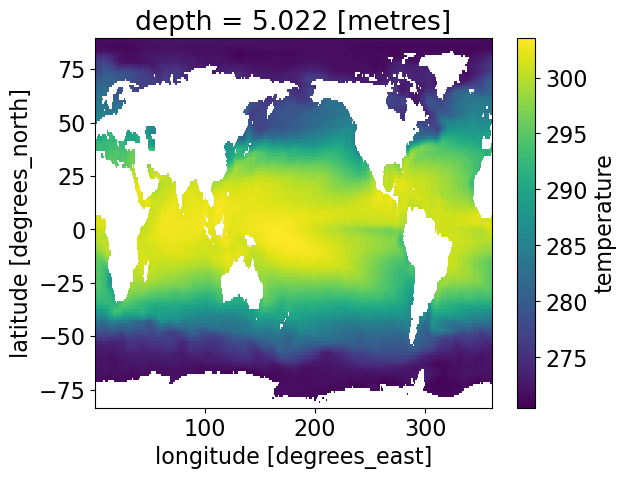

In [63]:
en4_dset.temperature.isel(depth=0).mean(dim='time').plot()

## Load ERA5 surface flux data with xarray

In [23]:
era5_dir = '/Users/dgwynevans/Dropbox/work_general/dev/wmt/data/external/ERA5/ERA5_surfaceflux_2020.nc'
era5_dset = xr.open_dataset(era5_dir)
era5_dset

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 12)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-12-01
Data variables:
    e          (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 ...
    slhf       (time, latitude, longitude) float32 ...
    ssr        (time, latitude, longitude) float32 ...
    str        (time, latitude, longitude) float32 ...
    sshf       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-20 11:13:34 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [59]:
era5_dir = '/Users/dgwynevans/Dropbox/work_general/dev/wmt/data/external/ERA5/ERA5_surfaceflux_2019.nc'
era5_dset = xr.open_dataset(era5_dir)

In [58]:
# new_era5_dir = '/Users/dgwynevans/Dropbox/work_general/dev/wmt/data/external/ERA5/ERA5_surfaceflux_2019.nc'
# era5_dset_2019 = era5_dset.isel(time=(era5_dset.time>=np.datetime64('2019-01-01')) & (era5_dset.time<np.datetime64('2020-01-01')))
# era5_dset_2019.to_netcdf(new_era5_dir)

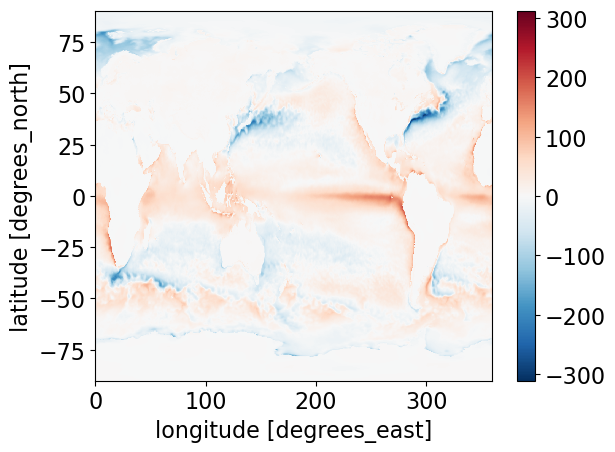

In [61]:
qnet = (era5_dset.ssr + era5_dset.str + era5_dset.slhf + era5_dset.sshf) / (24*60*60)
qnet.mean(dim='time').plot()

## Create empty ts_trans dataset

In [64]:
dS = 0.025
dT = 0.25
S_range = (25, 40)
T_range = (-3, 32)

ts_trans = mk_ts_trans_ds(dS, dT, S_range, T_range, en4_dset.time.data)

ts_trans

<xarray.Dataset>
Dimensions:   (T_bini: 140, S_bini: 600, time: 12, time_mid: 10, T_binii: 139,
               S_binii: 599, T_bin: 141, S_bin: 601, T_binj: 142, S_binj: 602)
Coordinates:
  * T_bin     (T_bin) float64 -3.0 -2.75 -2.5 -2.25 ... 31.25 31.5 31.75 32.0
  * S_bin     (S_bin) float64 25.0 25.02 25.05 25.07 ... 39.92 39.95 39.97 40.0
  * T_bini    (T_bini) float64 -2.875 -2.625 -2.375 -2.125 ... 31.38 31.62 31.88
  * S_bini    (S_bini) float64 25.01 25.04 25.06 25.09 ... 39.94 39.96 39.99
  * T_binii   (T_binii) float64 -2.75 -2.5 -2.25 -2.0 ... 31.0 31.25 31.5 31.75
  * S_binii   (S_binii) float64 25.02 25.05 25.07 25.1 ... 39.92 39.95 39.97
  * T_binj    (T_binj) float64 -3.125 -2.875 -2.625 -2.375 ... 31.62 31.88 32.12
  * S_binj    (S_binj) float64 24.99 25.01 25.04 25.06 ... 39.96 39.99 40.01
  * time      (time) datetime64[ns] 2019-01-16T12:00:00 ... 2019-12-16T12:00:00
  * time_mid  (time_mid) datetime64[ns] 2019-02-15 ... 2019-11-16
    dT        float64 0.25
    dS        float64 0.025
Data variables: (12/24)
    ts_vol    (T_bini, S_bini, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ts_lat    (T_bini, S_bini, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ts_lon    (T_bini, S_bini, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ts_dep    (T_bini, S_bini, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dvol_G    (T_bini, S_bini, time_mid) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dvol_E    (T_bini, S_bini, time_mid) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...        ...
    E_ti      (T_bini, S_bini, time_mid) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    E_si      (T_bini, S_bini, time_mid) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    F_ti      (T_bini, S_bini, time_mid) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    F_si      (T_bini, S_bini, time_mid) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    M_ti      (T_bini, S_bini, time_mid) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    M_si      (T_bini, S_bini, time_mid) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

Calculate T/S volume

In [65]:
salinity = en4_dset.salinity
temperature = en4_dset.temperature - 273.15

ts_trans = calc_ts_volume(
    salinity, temperature, ts_trans, 
    en4_dset.lat.data, 
    en4_dset.lon.data, 
    en4_dset.depth.data, 
    use_gsw=True
    )

/Users/dgwynevans/opt/anaconda3/envs/wmt_env/lib/python3.12/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


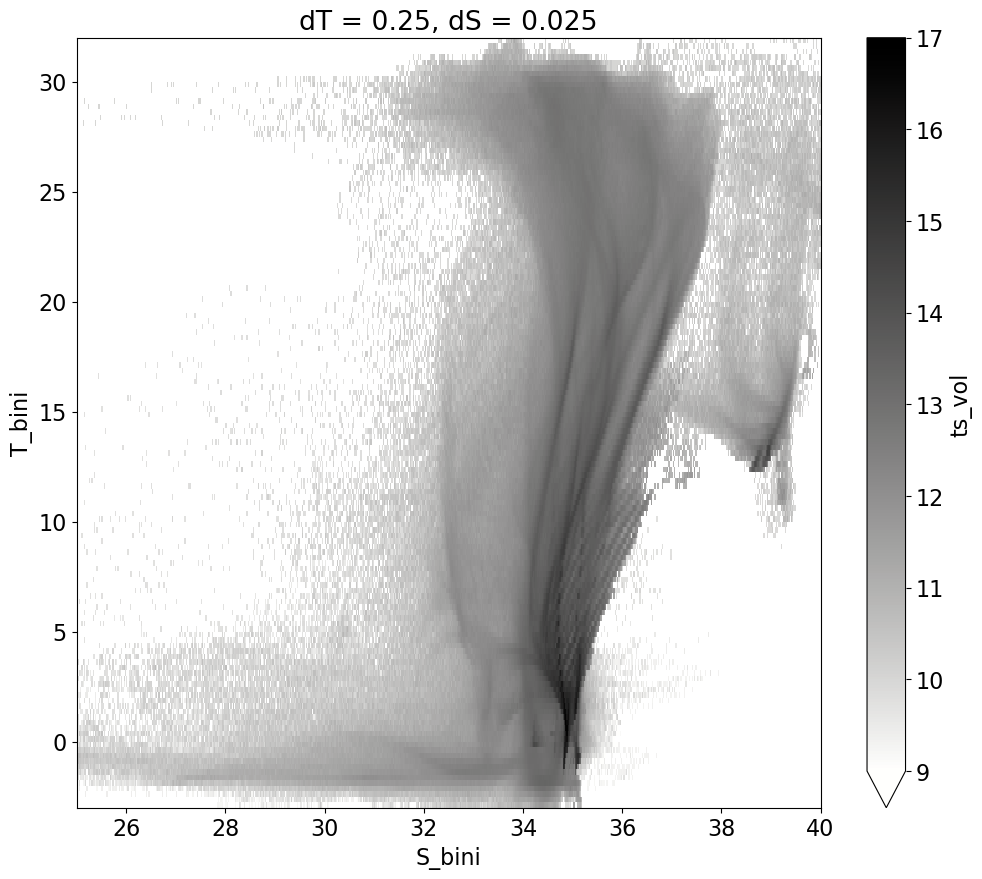

In [66]:
np.log10(ts_trans.ts_vol.mean(dim='time')).plot(figsize=(12,10), cmap=cmocean.cm.gray_r, vmin=9, vmax=17)

## Calculate T/S transformation

In [67]:
dt = (30 * 24 * 60 * 60)
ts_trans = ts_trans_cdiff(ts_trans, dt)

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
/var/folders/pz/3wy65hsn42n3v_1fd942fb6w0000gr/T/ipykernel_78544/1871575041.py:12: SyntaxWarning: invalid escape sequence '\c'
  ax[0].set_ylabel('CT [$^\circ$C]')


Text(0, 0.5, 'SA [g/kg]')

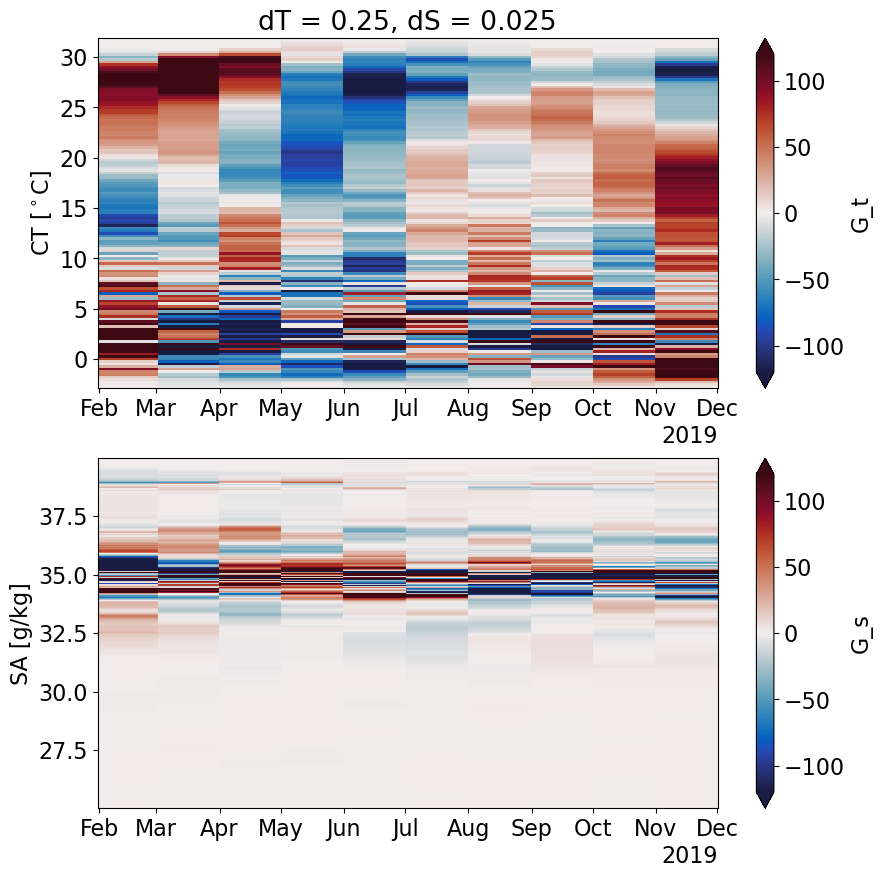

In [68]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

((ts_trans.G_t - ts_trans.G_t.mean(dim='time_mid')).sum(dim='S_bini')/1e6).plot(
    ax=ax[0], vmin=-120, vmax=120, cmap=cmocean.cm.balance)

((ts_trans.G_s - ts_trans.G_s.mean(dim='time_mid')).sum(dim='T_bini')/1e6).plot(
    ax=ax[1], vmin=-120, vmax=120, cmap=cmocean.cm.balance)

ax[1].set_title(None)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[0].set_ylabel('CT [$^\circ$C]')
ax[1].set_ylabel('SA [g/kg]')

## Calculate surface forced water mass tranformation

In [69]:
# Interpolate EN4 to ERA5 spatial resolution
en4_surf_dset = en4_dset.isel(depth=0).interp(lat=era5_dset.latitude, lon=era5_dset.longitude)

# Interpolate ERA5 onto the EN4 temporal resolution
era5_dset = era5_dset.interp(time=ts_trans.time_mid)

# Calculate qnet and fnet
qnet = (era5_dset.ssr + era5_dset.str + era5_dset.slhf + era5_dset.sshf) / (24*60*60) # Convert to W m^-2
fnet = (np.abs(era5_dset.e) - era5_dset.tp) / (24*60*60) # Convert to m s^-1

# Calculate the air-sea flux transformation
ts_trans = calc_surf_trans(
    ts_trans, qnet, fnet, 
    en4_surf_dset.temperature - 273.15, 
    en4_surf_dset.salinity, 
    era5_dset.longitude, 
    era5_dset.latitude,
    )

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
/var/folders/pz/3wy65hsn42n3v_1fd942fb6w0000gr/T/ipykernel_78544/469212036.py:12: SyntaxWarning: invalid escape sequence '\c'
  ax[0].set_ylabel('CT [$^\circ$C]')


Text(0, 0.5, 'SA [g/kg]')

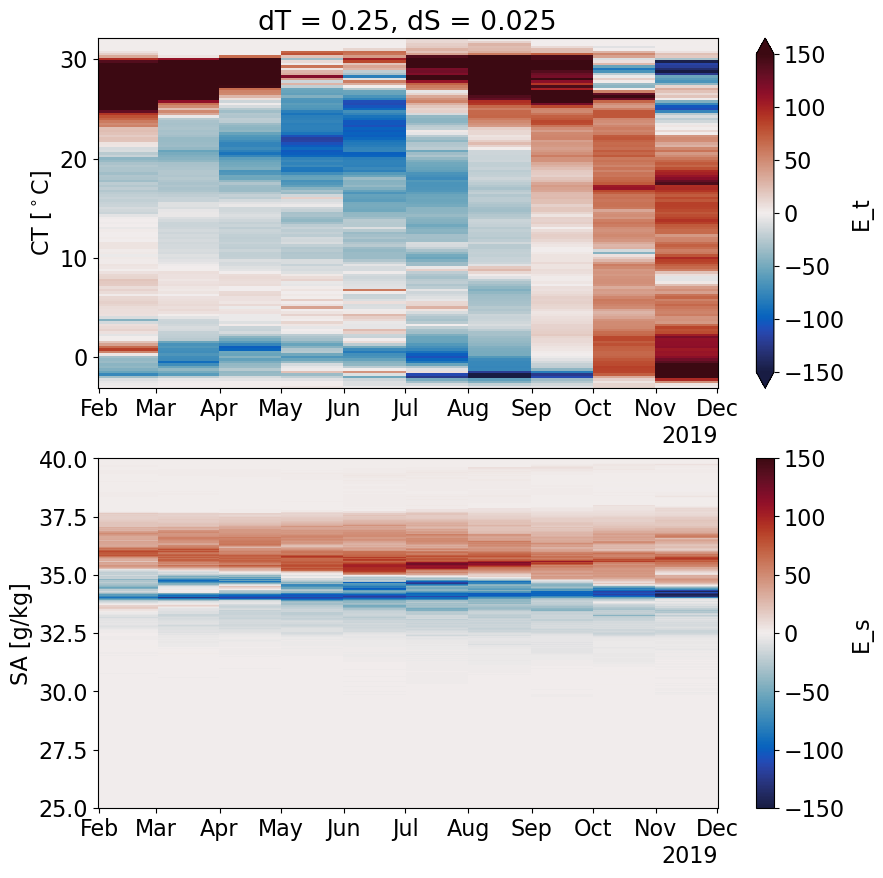

In [70]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

(ts_trans.E_t.sum(dim='S_bini')/1e6).plot(
    ax=ax[0], vmin=-150, vmax=150, cmap=cmocean.cm.balance)

(ts_trans.E_s.sum(dim='T_bini')/1e6).plot(
    ax=ax[1], vmin=-150, vmax=150, cmap=cmocean.cm.balance)

ax[1].set_title(None)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[0].set_ylabel('CT [$^\circ$C]')
ax[1].set_ylabel('SA [g/kg]')

## Load OSNAP data and calculate overturning in T/S space

In [71]:
dset_dir = '/Users/dgwynevans/Dropbox/work_general/dev/wmt/data/external/OSNAP/OSNAP_Gridded_TSV_201408_202006_2023.nc'

osnap_dset = xr.open_dataset(dset_dir)

SA = gsw.SA_from_SP(osnap_dset.SAL, gsw.p_from_z(-osnap_dset.DEPTH, osnap_dset.LATITUDE.mean()), osnap_dset.LONGITUDE, np.nanmean(osnap_dset.LATITUDE))
CT = gsw.CT_from_t(SA, osnap_dset.TEMP, 0)

osnap_dset = osnap_dset.assign({'SA': SA, 'CT': CT})

time_idx = (ts_trans['time_mid']>=osnap_dset.TIME[0]) & (ts_trans['time_mid']<=osnap_dset.TIME[-1])
osnap_dset = osnap_dset.interp(TIME=ts_trans['time_mid'][time_idx])

dset_dir = '/Users/dgwynevans/Dropbox/work_general/dev/wmt/data/external//OSNAP/OSNAP_Gridded_TSV_201408_201805_2020.nc'
old_osnap_dset = xr.open_dataset(dset_dir)

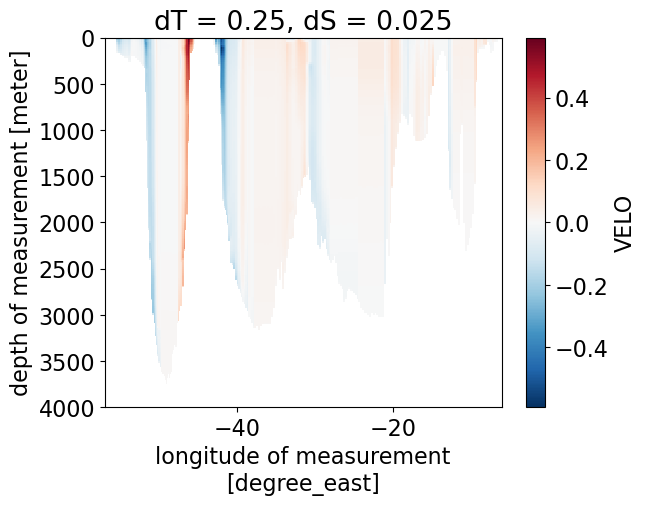

In [74]:
osnap_dset.VELO.mean(dim='time_mid').plot(ylim=(4000, 0))

In [75]:
ts_trans['dvol_M'] = ts_trans.dvol_M.sel(time_mid=osnap_dset.time_mid).rename({'time_mid': 'time_osnap'})
ts_trans['M_t'] = ts_trans.M_t.sel(time_mid=osnap_dset.time_mid).rename({'time_mid': 'time_osnap'})
ts_trans['M_s'] = ts_trans.M_s.sel(time_mid=osnap_dset.time_mid).rename({'time_mid': 'time_osnap'})
ts_trans['M_ti'] = ts_trans.M_ti.sel(time_mid=osnap_dset.time_mid).rename({'time_mid': 'time_osnap'})
ts_trans['M_si'] = ts_trans.M_si.sel(time_mid=osnap_dset.time_mid).rename({'time_mid': 'time_osnap'})

In [76]:
def calc_OSNAP_dvol(osnap_dset, old_osnap_dset, ts_trans, dt):
    
    bin_edge1 = ts_trans.T_bin
    bin_edge2 = ts_trans.S_bin

    dvol = np.zeros((len(ts_trans.T_bini), len(ts_trans.S_bini), len(osnap_dset.time_mid)))

    for ii in np.arange(len(osnap_dset.time_mid)):

        bin1 = osnap_dset.CT[ii, :, :].data
        bin2 = osnap_dset.SA[ii, :, :].data
        var = osnap_dset.VELO[ii, :, :].data * old_osnap_dset.AREA.data

        out = bin_3D_field_2D(var, bin1, bin2, bin_edge1, bin_edge2, 'sum')
        ts_trans['dvol_M'][:, :, ii] = out[0] * dt
        
    return ts_trans

ts_trans = calc_OSNAP_dvol(osnap_dset, old_osnap_dset, ts_trans, 30*24*60*60)

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
/var/folders/pz/3wy65hsn42n3v_1fd942fb6w0000gr/T/ipykernel_78544/2338342599.py:12: SyntaxWarning: invalid escape sequence '\c'
  ax[0].set_ylabel('CT [$^\circ$C]')


Text(0, 0.5, 'SA [g/kg]')

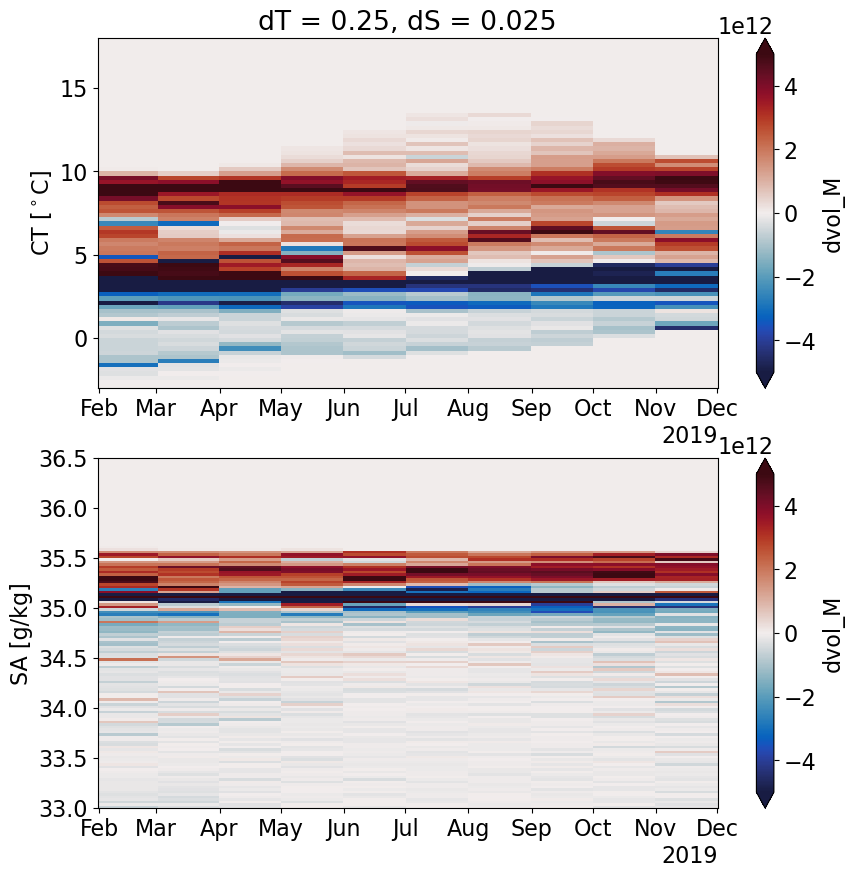

In [77]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

(ts_trans.dvol_M.sum(dim='S_bini')).plot(
    ax=ax[0], vmin=-5e12, vmax=5e12, ylim=(-3,18), cmap=cmocean.cm.balance)

(ts_trans.dvol_M.sum(dim='T_bini')).plot(
    ax=ax[1], vmin=-5e12, vmax=5e12, ylim=(33,36.5), cmap=cmocean.cm.balance)

ax[1].set_title(None)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[0].set_ylabel('CT [$^\circ$C]')
ax[1].set_ylabel('SA [g/kg]')

In [78]:
ts_trans = calc_osnap_M(ts_trans)

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
/var/folders/pz/3wy65hsn42n3v_1fd942fb6w0000gr/T/ipykernel_78544/3558660504.py:12: SyntaxWarning: invalid escape sequence '\c'
  ax[0].set_ylabel('CT [$^\circ$C]')


Text(0, 0.5, 'SA [g/kg]')

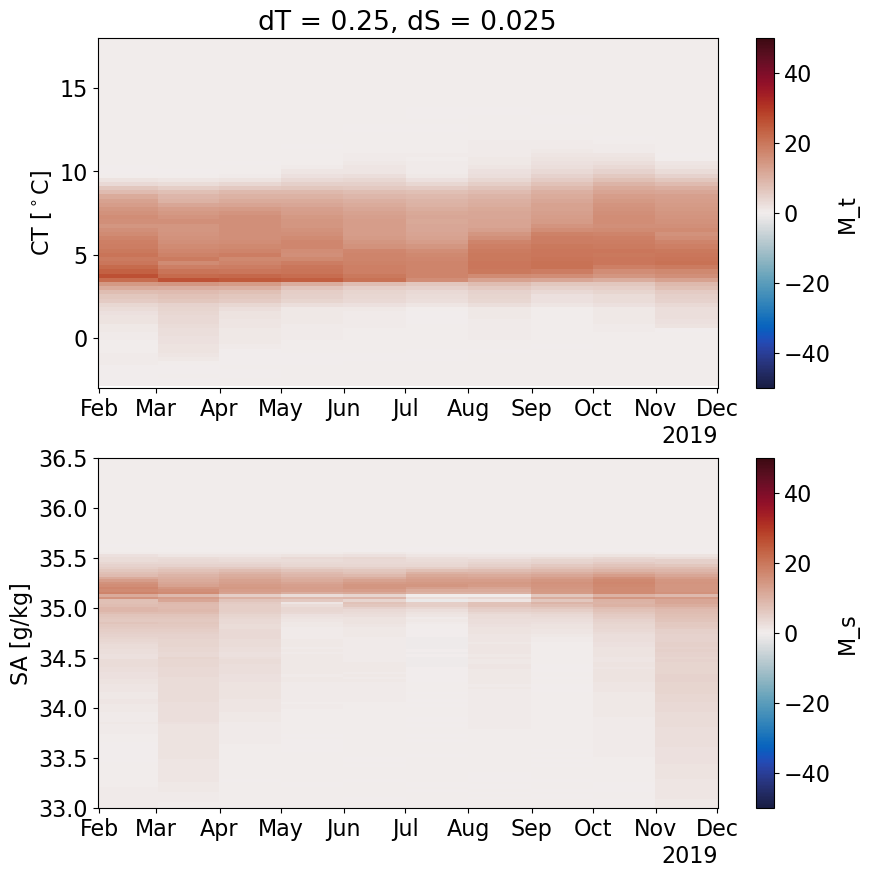

In [79]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

(ts_trans.M_t.sum(dim='S_bini')/1e6).plot(
    ax=ax[0], vmin=-50, vmax=50, ylim=(-3,18), cmap=cmocean.cm.balance)

(ts_trans.M_s.sum(dim='T_bini')/1e6).plot(
    ax=ax[1], vmin=-50, vmax=50, ylim=(33,36.5), cmap=cmocean.cm.balance)

ax[1].set_title(None)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[0].set_ylabel('CT [$^\circ$C]')
ax[1].set_ylabel('SA [g/kg]')

## Calculate the residual transformation

In [80]:
ts_trans['dvol_F'] = ts_trans.dvol_G.sel(time_mid=ts_trans.time_osnap) - ts_trans.dvol_E.sel(time_mid=ts_trans.time_osnap) - ts_trans.dvol_M
ts_trans['dvol_F'] = ts_trans.dvol_F.where(~np.isnan(ts_trans['dvol_F']), 0)

In [81]:

ts_trans['F_t'] = ts_trans.F_t.sel(time_mid=osnap_dset.time_mid).rename({'time_mid': 'time_osnap'})
ts_trans['F_s'] = ts_trans.F_s.sel(time_mid=osnap_dset.time_mid).rename({'time_mid': 'time_osnap'})
ts_trans['F_ti'] = ts_trans.F_ti.sel(time_mid=osnap_dset.time_mid).rename({'time_mid': 'time_osnap'})
ts_trans['F_si'] = ts_trans.F_si.sel(time_mid=osnap_dset.time_mid).rename({'time_mid': 'time_osnap'})

In [82]:
ts_trans = calc_osanp_F(ts_trans, 30*24*60*60)

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
/var/folders/pz/3wy65hsn42n3v_1fd942fb6w0000gr/T/ipykernel_78544/4027447965.py:12: SyntaxWarning: invalid escape sequence '\c'
  ax[0].set_ylabel('CT [$^\circ$C]')


Text(0, 0.5, 'SA [g/kg]')

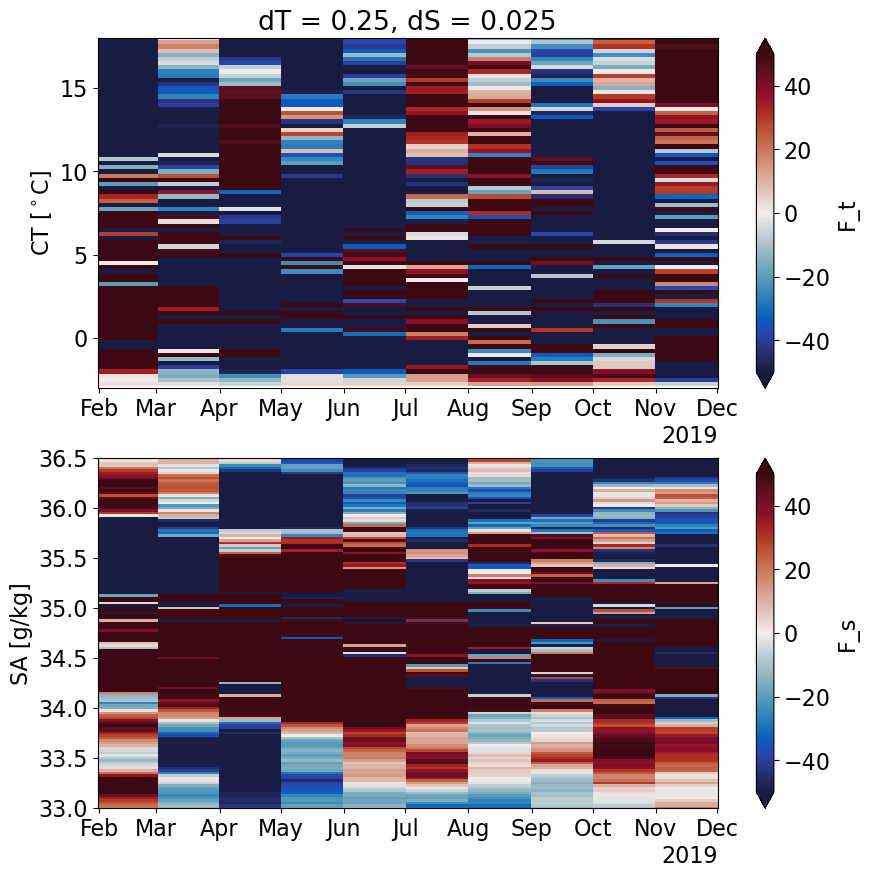

In [83]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

(ts_trans.F_t.sum(dim='S_bini')/1e6).plot(
    ax=ax[0], vmin=-50, vmax=50, ylim=(-3,18), cmap=cmocean.cm.balance)

(ts_trans.F_s.sum(dim='T_bini')/1e6).plot(
    ax=ax[1], vmin=-50, vmax=50, ylim=(33,36.5), cmap=cmocean.cm.balance)

ax[1].set_title(None)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[0].set_ylabel('CT [$^\circ$C]')
ax[1].set_ylabel('SA [g/kg]')

In [90]:
def plot_trans(fig, ax, x, y, var, u, v, dens_g, ylim, xlim, clim, title, labels, scale=5e7, max_sig = 27.675):
    
    lsw = (34.8, 3)
    lsw_wh = (0.1, 1)
    ow = (34.9, 3)
    ow_wh = (0.1, 1)
    
    # Plot dvol
    cs = ax.pcolormesh(x, y, var, vmin=clim[0], vmax=clim[1], cmap=cmocean.cm.balance)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_title(title)
    
    # Add density contour
    CS_dens = ax.contour(x, y, dens_g, np.arange(20, 30, 1), colors='k')
    ax.contour(x, y, dens_g, levels=[max_sig], colors='k', linestyles='dashed')
    ax.clabel(CS_dens, fmt='%2.0f')

    # Resize u and v
    nan_idx_u = np.isnan(u)
    nan_idx_v = np.isnan(v)

    u[nan_idx_u] = 0
    v[nan_idx_v] = 0
    
    fu = interp2d(x, y, u, kind='linear', fill_value=np.nan)
    fv = interp2d(x, y, v, kind='linear', fill_value=np.nan)

    xy_step = 2
    x_idx = np.arange(0, len(x), xy_step)
    y_idx = np.arange(0, len(y), xy_step)

    ui = fu(x[x_idx], y[y_idx])
    vi = fv(x[x_idx], y[y_idx])

    # Remove when both u and v are zero
    x_g, y_g = np.meshgrid(x[x_idx], y[y_idx])

    ui = ui.flatten()
    vi = vi.flatten()
    x_g = x_g.flatten()
    y_g = y_g.flatten()

    keep_idx = (ui != 0) & (vi != 0)
    ui = ui[keep_idx]
    vi = vi[keep_idx]
    x_g = x_g[keep_idx]
    y_g = y_g[keep_idx]

    # Plot transformations
    ax.quiver(x_g, y_g, ui, vi, angles='uv', headwidth=5, color=[0.25, 0.25, 0.25], scale=scale)
    
    # rect_lsw = patches.Rectangle(lsw, lsw_wh[0], lsw_wh[1], linewidth = 1, edgecolor='k', facecolor='none')
    # rect_ow = patches.Rectangle(ow, ow_wh[0], ow_wh[1], linewidth = 1, edgecolor='k', facecolor='none')
    # ax.add_patch(rect_lsw)
    # ax.add_patch(rect_ow)

    return cs

def plot_trans_vol(fig, ax, x, y, var, vol, u, v, dens_g, ylim, xlim, clim, title, labels, scale=5e7, max_sig = 27.675):
    
    lsw = (34.8, 3)
    lsw_wh = (0.1, 1)
    ow = (34.9, 3)
    ow_wh = (0.1, 1)
    
    # Plot dvol
    cs = ax.pcolormesh(x, y, var, vmin=clim[0], vmax=clim[1], cmap=cmocean.cm.balance)
    ax.contour(x, y, np.log10(vol), levels=np.arange(10, 16, 1), cmap=cmocean.cm.gray_r)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_title(title)
    
    # Add density contour
    CS_dens = ax.contour(x, y, dens_g, np.arange(20, 30, 1), colors='k')
    ax.contour(x, y, dens_g, levels=[max_sig], colors='k', linestyles='dashed')
    ax.clabel(CS_dens, fmt='%2.0f')

    # Resize u and v
    nan_idx_u = np.isnan(u)
    nan_idx_v = np.isnan(v)

    u[nan_idx_u] = 0
    v[nan_idx_v] = 0
    
    fu = interp2d(x, y, u, kind='linear', fill_value=np.nan)
    fv = interp2d(x, y, v, kind='linear', fill_value=np.nan)

    xy_step = 4
    x_idx = np.arange(0, len(x), xy_step)
    y_idx = np.arange(0, len(y), xy_step)

    ui = fu(x[x_idx], y[y_idx])
    vi = fv(x[x_idx], y[y_idx])

    # Remove when both u and v are zero
    x_g, y_g = np.meshgrid(x[x_idx], y[y_idx])

    ui = ui.flatten()
    vi = vi.flatten()
    x_g = x_g.flatten()
    y_g = y_g.flatten()

    keep_idx = (ui != 0) & (vi != 0)
    ui = ui[keep_idx]
    vi = vi[keep_idx]
    x_g = x_g[keep_idx]
    y_g = y_g[keep_idx]

    # Plot transformations
    ax.quiver(x_g, y_g, ui, vi, angles='uv', headwidth=5, color=[0.25, 0.25, 0.25], scale=scale)
    
    # rect_lsw = patches.Rectangle(lsw, lsw_wh[0], lsw_wh[1], linewidth = 1, edgecolor='k', facecolor='none')
    # rect_ow = patches.Rectangle(ow, ow_wh[0], ow_wh[1], linewidth = 1, edgecolor='k', facecolor='none')
    # ax.add_patch(rect_lsw)
    # ax.add_patch(rect_ow)

    return cs

/var/folders/pz/3wy65hsn42n3v_1fd942fb6w0000gr/T/ipykernel_78544/2245777216.py:71: RuntimeWarning: divide by zero encountered in log10
  ax.contour(x, y, np.log10(vol), levels=np.arange(10, 16, 1), cmap=cmocean.cm.gray_r)
/var/folders/pz/3wy65hsn42n3v_1fd942fb6w0000gr/T/ipykernel_78544/2245777216.py:90: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  fu = interp2d(x, y, u, kind='linear', fill_value=np.nan)
/var/folders/pz/3wy65hsn42n3v_1fd942fb6w0000gr/T/ipykernel_78544/2245777216.py:91: DeprecationWarning: `interp2

Text(0, 0.5, 'Volume change [m$^3$]')

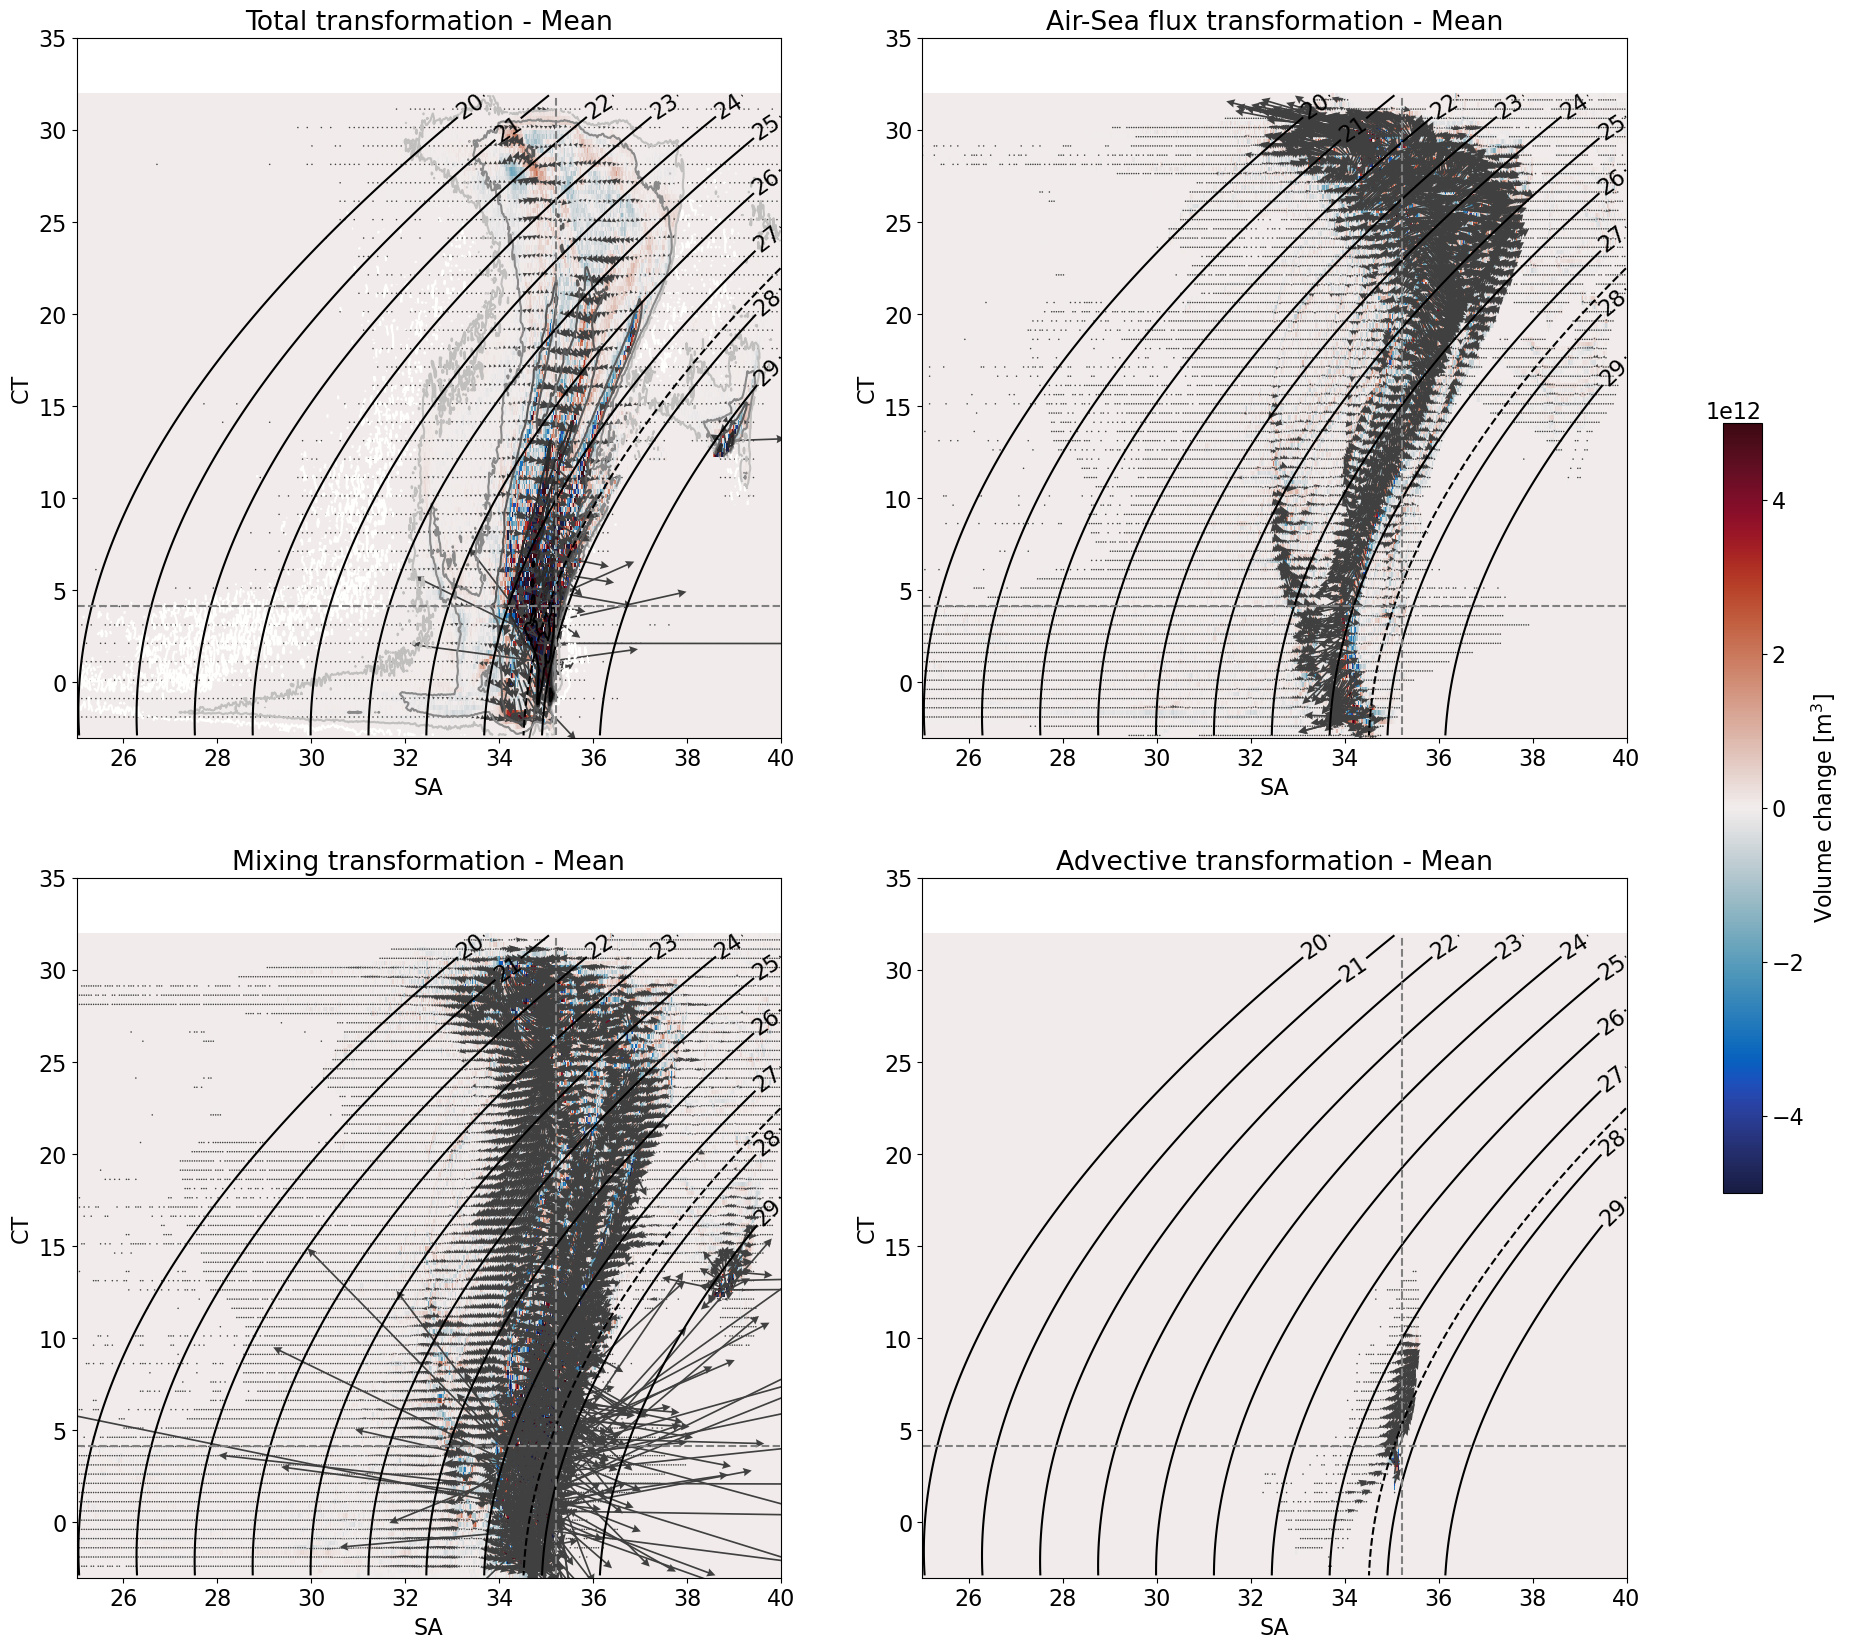

In [91]:
S_g, T_g = np.meshgrid(ts_trans.S_bini, ts_trans.T_bini)
# dens_g = gsw.rho(S_g, T_g, 0) - 1000
dens_g = gsw.rho(S_g, T_g, 0) - 1000

fig, ax = plt.subplots(2, 2, figsize=(25,20))

clim = (-5e12, 5e12)
ylim = (-3, 35)
xlim = (25, 40)

labels = ('SA', 'CT')

x = ts_trans.S_bini.copy()
y = ts_trans.T_bini.copy()

max_T = ts_trans['T_bini'][np.where(ts_trans.M_t.sum(dim='S_bini').mean(dim='time_osnap')/1e6 == np.nanmax(ts_trans.M_t.sum(dim='S_bini').mean(dim='time_osnap')/1e6))]
max_S = ts_trans['S_bini'][np.where(ts_trans.M_s.sum(dim='T_bini').mean(dim='time_osnap')/1e6 == np.nanmax(ts_trans.M_s.sum(dim='T_bini').mean(dim='time_osnap')/1e6))]

mean_vol = ts_trans.ts_vol.sel(time=ts_trans.time_osnap).mean(dim="time_osnap").data
var = ts_trans.dvol_G.sel(time_mid=ts_trans.time_osnap).mean(dim="time_osnap").data
u = ts_trans.G_si.sel(time_mid=ts_trans.time_osnap).mean(dim="time_osnap").data
v = ts_trans.G_ti.sel(time_mid=ts_trans.time_osnap).mean(dim="time_osnap").data
title = 'Total transformation - Mean'

cs = plot_trans_vol(fig, ax[0,0], x, y, var, mean_vol, u, v, dens_g, ylim, xlim, clim, title, labels, max_sig=27.68)
ax[0,0].hlines(max_T, np.min(ts_trans['S_bini']), np.max(ts_trans['S_bini']), linestyle='--', color='gray')
ax[0,0].vlines(max_S, np.min(ts_trans['T_bini']), np.max(ts_trans['T_bini']), linestyle='--', color='gray')
    
var =ts_trans.dvol_E.sel(time_mid=ts_trans.time_osnap).mean(dim="time_osnap").data
u = ts_trans.E_si.sel(time_mid=ts_trans.time_osnap).mean(dim="time_osnap").data
v = ts_trans.E_ti.sel(time_mid=ts_trans.time_osnap).mean(dim="time_osnap").data
title = 'Air-Sea flux transformation - Mean'

cs = plot_trans(fig, ax[0,1], x, y, var, u, v, dens_g, ylim, xlim, clim, title, labels, max_sig=27.68)
ax[0,1].hlines(max_T, np.min(ts_trans['S_bini']), np.max(ts_trans['S_bini']), linestyle='--', color='gray')
ax[0,1].vlines(max_S, np.min(ts_trans['T_bini']), np.max(ts_trans['T_bini']), linestyle='--', color='gray')

var =ts_trans.dvol_F.mean(dim="time_osnap").data
u = ts_trans.F_si.mean(dim="time_osnap").data
v = ts_trans.F_ti.mean(dim="time_osnap").data
title = 'Mixing transformation - Mean'

cs = plot_trans(fig, ax[1,0], x, y, var, u, v, dens_g, ylim, xlim, clim, title, labels, max_sig=27.68)
ax[1,0].hlines(max_T, np.min(ts_trans['S_bini']), np.max(ts_trans['S_bini']), linestyle='--', color='gray')
ax[1,0].vlines(max_S, np.min(ts_trans['T_bini']), np.max(ts_trans['T_bini']), linestyle='--', color='gray')

var =ts_trans.dvol_M.mean(dim="time_osnap").data
u = ts_trans.M_si.mean(dim="time_osnap").data
v = ts_trans.M_ti.mean(dim="time_osnap").data
title = 'Advective transformation - Mean'

cs = plot_trans(fig, ax[1,1], x, y, var, u, v, dens_g, ylim, xlim, clim, title, labels, max_sig=27.68)
ax[1,1].hlines(max_T, np.min(ts_trans['S_bini']), np.max(ts_trans['S_bini']), linestyle='--', color='gray')
ax[1,1].vlines(max_S, np.min(ts_trans['T_bini']), np.max(ts_trans['T_bini']), linestyle='--', color='gray')

cbar = fig.colorbar(cs, ax=ax.ravel().tolist(), shrink=0.5)
cbar.ax.set_ylabel('Volume change [m$^3$]')